In [1]:
!pip install torch torchvision torchaudio


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity


In [5]:
data = pd.read_csv("./no2_data.csv", encoding="latin1")
x = data["no2"].dropna().values.reshape(-1, 1)
print("Samples:", x.shape[0])


/tmp/ipython-input-1635912807.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./no2_data.csv", encoding="latin1")


Samples: 419509


In [6]:
# My Roll Number
r = 102497020

a_r = 1.5
b_r = 0.6

z = x + a_r * np.sin(b_r * x)


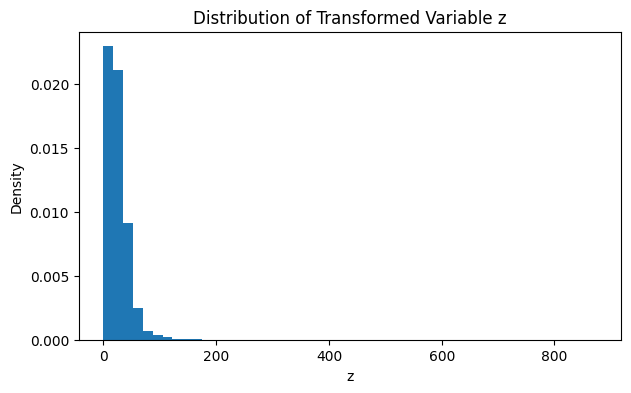

In [ ]:
plt.figure(figsize=(7,4))
plt.hist(z, bins=50, density=True)
plt.xlabel("z")
plt.ylabel("Density")
plt.title("Distribution of Transformed Variable z")
plt.show()


In [8]:
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)

z_tensor = torch.tensor(z_scaled, dtype=torch.float32)


In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [11]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()

g_optimizer = optim.Adam(G.parameters(), lr=0.001)
d_optimizer = optim.Adam(D.parameters(), lr=0.001)


In [12]:
epochs = 3000
batch_size = 128

for epoch in range(epochs):
    idx = np.random.randint(0, z_tensor.shape[0], batch_size)
    real_samples = z_tensor[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    # ---- Train Discriminator ----
    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)

    d_loss_real = criterion(D(real_samples), real_labels)
    d_loss_fake = criterion(D(fake_samples.detach()), fake_labels)
    d_loss = d_loss_real + d_loss_fake

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # ---- Train Generator ----
    g_loss = criterion(D(fake_samples), real_labels)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 0 | D Loss: 1.3900 | G Loss: 0.6612
Epoch 500 | D Loss: 1.3544 | G Loss: 0.6727
Epoch 1000 | D Loss: 1.3776 | G Loss: 0.7762
Epoch 1500 | D Loss: 1.2776 | G Loss: 0.6230
Epoch 2000 | D Loss: 1.3936 | G Loss: 0.6916
Epoch 2500 | D Loss: 1.2801 | G Loss: 0.7485


In [13]:
with torch.no_grad():
    noise = torch.randn(10000, 1)
    generated_z = G(noise).numpy()

generated_z = scaler.inverse_transform(generated_z)


In [14]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.3)
kde.fit(generated_z)

z_range = np.linspace(z.min(), z.max(), 1000).reshape(-1, 1)
log_density = kde.score_samples(z_range)
density = np.exp(log_density)


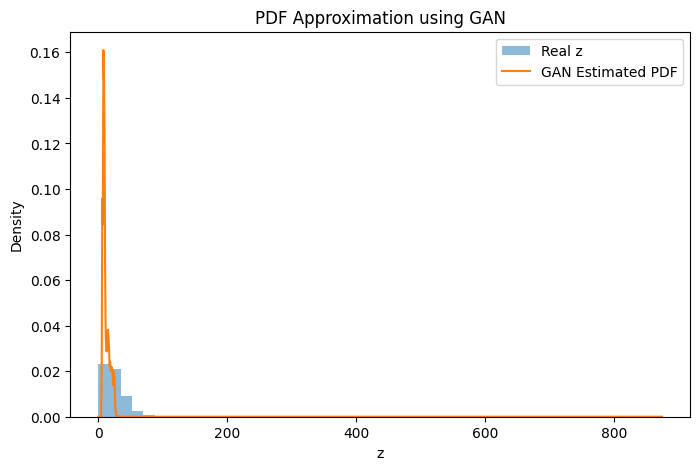

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(z, bins=50, density=True, alpha=0.5, label="Real z")
plt.plot(z_range, density, label="GAN Estimated PDF")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.title("PDF Approximation using GAN")
plt.show()
